#**Image Colorization Through Encoder Decoder Part 3**

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
import os
import torchvision.transforms as tt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from skimage.color import lab2rgb, rgb2lab
import torch.nn as nn
import torch.nn.functional as F
from skimage.color import rgb2lab, lab2rgb
from torchvision import models
from PIL import Image

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # 128 x 1 x 256 x 256
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 128 x 64 x 128 x 128

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 128 x 128 x 128 x 128

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 128 x 128 x 64 x 64

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # 128 x 256 x 64 x 64

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # 128 x 256 x 32 x 32

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # 128 x 512 x 32 x 32

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # 128 x 512 x 32 x 32

            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.Tanh()
        )
        # 128 x 256 x 32 x 32

    def forward(self, x):
        return self.encoder(x.float())

In [ ]:
class Feature_Extraction(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inv3_img, enc_img):
        y = torch.stack([torch.stack([inv3_img], dim=2)], dim=3)
        y = y.repeat(1, 1, enc_img.shape[2], enc_img.shape[3])
        fusion_img = torch.cat((enc_img, y), axis=1)
        return fusion_img

In [ ]:
class After_Feature_Extraction(nn.Module):
    def __init__(self):
        super().__init__()
        self.ft = nn.Conv2d(1256, 256, kernel_size=1, stride=1, padding=0)

    def forward(self, fusion_img):
        return self.ft(fusion_img)

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            # 128 x 256 x 32 x 32

            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2.0, mode='nearest'),
            # 128 x 128 x 64 x 64

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 128 x 64 x 64 x 64

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2.0, mode='nearest'),
            # 128 x 64 x 128 x 128

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2.0, mode='nearest'),
            # 128 x 32 x 256 x 256

            nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(2),
            nn.Tanh()
            # 128 x 2 x 256 x 256
        )

    def forward(self, fuse_img):
        return self.decoder(fuse_img.float())

In [ ]:
def rgb_to_lab(img):
    lab = rgb2lab(img.permute(0, 2, 3, 1).cpu().numpy())
    l = lab[:, :, :, 0]/50.0
    l = l.reshape(l.shape+(1,))  #color dimension
    ab = lab[:, :, :, 1:]/128
    
    return to_device(torch.tensor(l, dtype=torch.float).permute(0, 3, 1, 2), device), to_device(torch.tensor(ab, dtype=torch.float).permute(0, 3, 1, 2), device)

In [ ]:
def stack_img(img):
    transform = tt.Resize(size=(299, 299))
    img = transform(img)
    img2 = img.repeat(1, 3, 1, 1)
    img2 = torch.tensor(img2)
    return img2

In [ ]:
inception_v3 = to_device(models.inception_v3(pretrained=True), device)
inception_v3.aux_logits = False

/home/pc35/Downloads/yes/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/pc35/Downloads/yes/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.ft_ex = Feature_Extraction()
        self.aft_ft_ex = After_Feature_Extraction()
        self.decoder = Decoder()

    def forward(self, L_img, test=False):
        inv3_img = inception_v3(stack_img(L_img))
        enc_img = self.encoder(L_img)
        fusion_img = self.ft_ex(inv3_img, enc_img)
        fusion_img = self.aft_ft_ex(fusion_img)
        dec_img = self.decoder(fusion_img)
        transform = tt.Resize(size=(256, 256))
        dec_img = transform(dec_img)
        return dec_img

    def training_step(self, batch):
        images, _ = batch
        L, AB = rgb_to_lab(images)
        out = self(L)  # 16 x 2 x 256 x 256
        loss = nn.MSELoss(reduction='mean')(out, AB)
        return loss

    def validation_step(self, batch):
        images, _ = batch
        L, AB = rgb_to_lab(images)
        out = self(L)
        loss = nn.MSELoss(reduction='mean')(out, AB)
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss']))

In [ ]:
model = BaseModel().to(device)
model

BaseModel(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affin

In [ ]:
model.load_state_dict(torch.load('person.pt', map_location='cpu'))

<All keys matched successfully>

In [ ]:
def show_image(img, model):
    img = img.unsqueeze(0)  # 1 x 3 x 256 x 256
    L,AB=rgb_to_lab(img)
    print(L.shape)
    print(AB.shape)
    inception_v3.eval()
    output=(model(L))
    out=torch.cat((L,output),axis=1)
    out[:,0,:,:]=out[:,0,:,:]*50
    out[:,1:3,:,:]=out[:,1:3,:,:]*128
    return out.squeeze(0)

In [ ]:
img=Image.open('pictures/p.jpg')
transform=tt.Compose([
    tt.Resize((256,256)),
    tt.ToTensor()]
)
img=transform(img)
output=show_image(img,model)
output.shape
output=output.permute(1,2,0).detach().cpu().numpy()
color=lab2rgb(output)

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])


/home/pc35/Downloads/yes/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Text(0.5, 1.0, 'B/W')

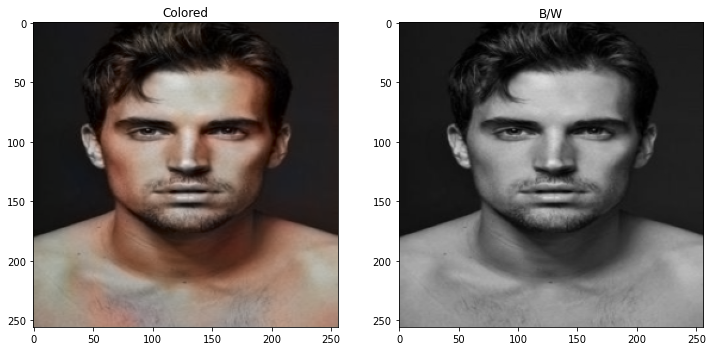

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(12,8))
ax[0].imshow(color)
ax[0].set_title("Colored")
ax[1].imshow(img.permute(1,2,0))
ax[1].set_title("B/W")

In [ ]:
#############################################################################################################

In [ ]:
!pip install opendatasets --quiet
import opendatasets as od

In [ ]:
od.download('https://www.kaggle.com/datasets/lijiyu/imagenet')

Skipping, found downloaded files in "./imagenet" (use force=True to force download)


In [ ]:
dir='imagenet/imagenet/'

In [ ]:
train_dir=dir+'train'
from PIL import Image

In [ ]:
img_size=256
train_tfms=tt.Compose([
    tt.Resize((256,256)),
    tt.ToTensor()]
)

In [ ]:
from torchvision.datasets import ImageFolder
dataset=ImageFolder(dir,train_tfms)

In [ ]:
val_size=0.75
train_ds,val_ds=random_split(dataset,[1-val_size,val_size])

In [ ]:
val_ds

In [ ]:
(len(train_ds),len(val_ds))

(12500, 37500)

In [ ]:
train_ds[4000][0][1]

tensor([[0.4118, 0.4078, 0.4863,  ..., 0.3608, 0.3098, 0.4392],
        [0.5255, 0.4941, 0.4588,  ..., 0.4824, 0.3961, 0.3216],
        [0.4667, 0.4118, 0.4039,  ..., 0.5137, 0.5255, 0.4471],
        ...,
        [0.3725, 0.4118, 0.5294,  ..., 0.3490, 0.1765, 0.0824],
        [0.6902, 0.5451, 0.4039,  ..., 0.2980, 0.4471, 0.6039],
        [0.4353, 0.6275, 0.6000,  ..., 0.2510, 0.3059, 0.4941]])

In [ ]:
L_img=rgb2lab(train_ds[4000][0].permute(1,2,0))
L=L_img[:,:,0]
L=L.reshape(L.shape+(1,)) 

In [ ]:
batch_size=16
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,pin_memory=True,num_workers=3)
val_dl=DataLoader(val_ds,batch_size=batch_size,pin_memory=True,num_workers=3)

In [ ]:
def show_batch(dl):
     for images, labels in dl:
        fig,ax=plt.subplots(figsize=(12,12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

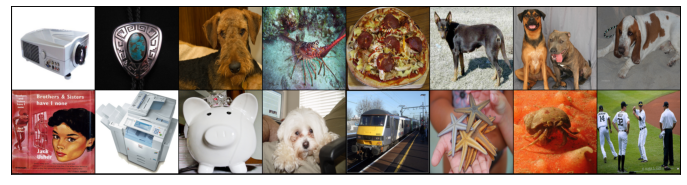

In [ ]:
show_batch(train_dl)

In [ ]:
model.load_state_dict(torch.load('model2.pt', map_location='cpu'))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm
@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()
    outputs=[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
  
def fit(epochs,lr,model,train_dl,val_dl,opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history=[]
    optimizer=opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        model.train()
        train_losses=[]
        for batch in tqdm(train_dl):
            loss=model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        history = torch.stack(train_losses).mean().item()
        
    return history

In [ ]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(val_dl,device)

In [ ]:
epochs=5
lr=0.005
optim_func=torch.optim.Adam

In [ ]:
history=[fit(epochs,lr,model,train_dl,val_dl,optim_func)]

  0%|          | 0/782 [00:00<?, ?it/s]/home/pc35/Downloads/yes/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
  2%|▏         | 17/782 [03:15<2:31:40, 11.90s/it]

In [ ]:
def show_image(img,model):
    img=img.unsqueeze(0) # 1 x 3 x 256 x 256
    L,AB=rgb_to_lab(img)
    print(L.shape)
    print(AB.shape)
    inception_v3.eval()
    output=(model(L))
    out=torch.cat((L,output),axis=1)
    out[:,0,:,:]=out[:,0,:,:]*50
    out[:,1:3,:,:]=out[:,1:3,:,:]*128
    return out.squeeze(0)

In [ ]:
output=show_image(val_ds[278][0],model)
output.shape

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])


/home/pc35/Downloads/yes/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([3, 256, 256])

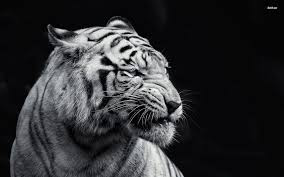

In [ ]:
img=Image.open('tiger.jpeg')
img

In [ ]:
transform=tt.Compose([tt.Resize((256,256)),tt.ToTensor()])
img=transform(img)
img

tensor([[[0.0196, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196],
         [0.0196, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196],
         [0.0196, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196],
         ...,
         [0.0196, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196],
         [0.0196, 0.0196, 0.0196,  ..., 0.0235, 0.0235, 0.0235],
         [0.0196, 0.0196, 0.0196,  ..., 0.0275, 0.0275, 0.0275]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196],
         [0.0196, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196],
         [0.0196, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196],
         ...,
         [0.0196, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196],
         [0.0196, 0.0196, 0.0196,  ..., 0.0235, 0.0235, 0.0235],
         [0.0196, 0.0196, 0.0196,  ..., 0.0275, 0.0275, 0.0275]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196],
         [0.0196, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196],
         [0.0196, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.

In [ ]:
output=show_image(img,model)
output.shape

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])


/home/pc35/Downloads/yes/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([3, 256, 256])

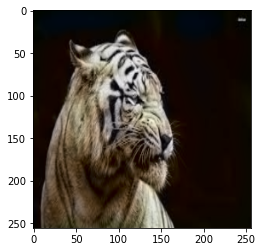

In [ ]:
output=output.permute(1,2,0).detach().cpu().numpy()
color=lab2rgb(output)
plt.imshow(color)

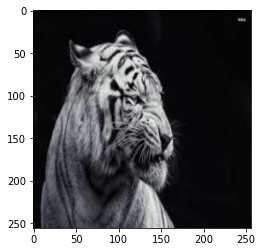

In [ ]:
plt.imshow(img.permute(1,2,0));